In [309]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd
import time
import datetime
%matplotlib inline

import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [453]:
dframe = pd.read_csv('tp1_19_may_sensordata.csv', sep=',', parse_dates=[1], header=None,
                         names=['datetime', 'sec', 'ms', 'event_type', 'event_subtype', 'sensor_id','z','x','y','value', 'something'])

In [454]:
dframe.tail()

,datetime,sec,ms,event_type,event_subtype,sensor_id,z,x,y,value,something
5861,2010.05.19 23:53:59,1274313239,969,R,0,6,702945,171,1,0,2130706433
5862,2010.05.19 23:56:01,1274313361,810,R,0,6,702973,182,1,0,2130706433
5863,2010.05.19 23:57:06,1274313426,860,R,0,6,702988,146,1,0,2130706433
5864,2010.05.19 23:57:23,1274313443,187,R,0,6,702995,176,1,3,2130706433
5865,2010.05.19 23:58:33,1274313513,289,R,0,6,703011,175,1,3,2130706433


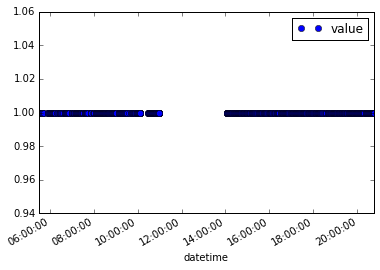

In [489]:
dframe['seconddelta'] = dframe.datetime.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )
dframe['msseconddelta'] = dframe.seconddelta + dframe.ms/1000

dframe['datetime'] = pd.to_datetime(dframe['datetime'])
pirdframe = pd.DataFrame(dframe.loc[dframe['sensor_id'] == 5])
reeddframe = pd.DataFrame(dframe.loc[dframe['sensor_id'] == 1])
pirdframe.plot(x='datetime', y='value', style='o')

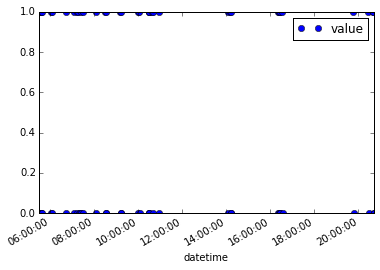

In [457]:
reeddframe.plot(x='datetime', y='value', style='o')

In [330]:
pirdframe.size

55029

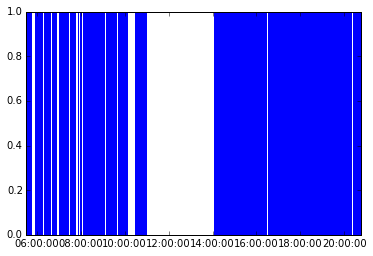

In [461]:
fig, ax = plt.subplots()
ax.stem(pirdframe.datetime, pirdframe.value, markerfmt=' ')
plt.figure(figsize=(2,2))
plt.show()

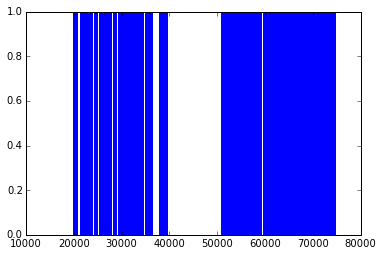

In [462]:
fig, ax = plt.subplots()
ax.stem(pirdframe.msseconddelta, pirdframe.value, markerfmt=' ')
plt.figure(figsize=(2,2))
plt.show()

In [463]:
PIR = pirdframe[['msseconddelta', 'value']].values
dpgmm1 = mixture.DPGMM(n_components=20, covariance_type='full', n_iter=100, init_params='wmc', params='c')
dpgmm1.fit(PIR)

DPGMM(alpha=1.0, covariance_type='full', init_params='wmc', min_covar=None,
   n_components=20, n_iter=100, params='c', random_state=None, thresh=None,
   tol=0.001, verbose=False)

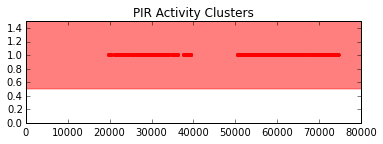

In [464]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
for i, (clf, title) in enumerate([(dpgmm1, 'Dirichlet Process GMM')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(PIR)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(PIR[Y_ == i, 0], PIR[Y_ == i, 1], 5, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(0, 80000)
    plt.ylim(0, 1.5)
    plt.title("PIR Activity Clusters")

In [465]:
# bett bewegungsmelder 146 PIR
pirbettdframe = pirdframe.loc[pirdframe['x'] == 146]

In [466]:
pirbettdframe.tail(5)

,datetime,sec,ms,event_type,event_subtype,sensor_id,z,x,y,value,something,seconddelta,msseconddelta
5495,2010-05-19 20:44:35,1274301875,844,R,0,5,700113,146,1,1,2130706433,74675,74675.844
5496,2010-05-19 20:44:42,1274301882,863,R,0,5,700117,146,1,1,2130706433,74682,74682.863
5497,2010-05-19 20:44:49,1274301889,717,R,0,5,700119,146,1,1,2130706433,74689,74689.717
5498,2010-05-19 20:44:55,1274301895,36,R,0,5,700123,146,1,1,2130706433,74695,74695.036
5499,2010-05-19 20:45:02,1274301902,266,R,0,5,700124,146,1,1,2130706433,74702,74702.266


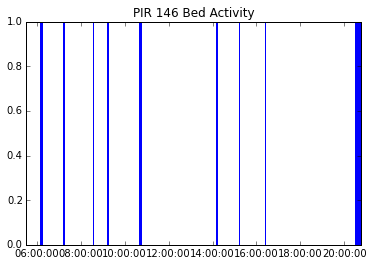

In [497]:
# bett bewegungsmelder 146 PIR
fig, ax = plt.subplots()
ax.stem(pirbettdframe.datetime, pirbettdframe.value, markerfmt=' ')
plt.title("PIR 146 Bed Activity")
plt.show()

In [468]:
# schlafzimmertür 176 REED
reedbedroomdframe = reeddframe.loc[reeddframe['x'] == 176]

In [469]:
reedbedroomdframe.size

247

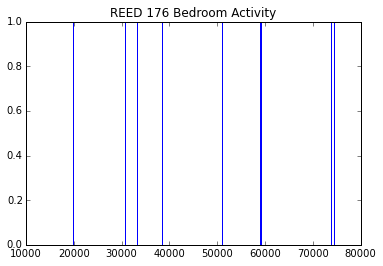

In [470]:
fig, ax = plt.subplots()
ax.stem(reedbedroomdframe.msseconddelta, reedbedroomdframe.value, markerfmt=' ')
plt.title("REED 176 Bedroom Activity")
plt.show()

In [521]:
# 176 REED && 146 PIR
#bedroomactivity = pd.DataFrame(pd.concat([pirbettdframe, reedbedroomdframe]))
bedroomactivity = pd.DataFrame(pirbettdframe)
bedroomactivity.sec = bedroomactivity.sec.astype(float)
bedroomactivity.dtypes

datetime         datetime64[ns]
sec                     float64
ms                        int64
event_type               object
event_subtype             int64
sensor_id                 int64
z                         int64
x                         int64
y                         int64
value                   float64
something                 int64
seconddelta               int64
msseconddelta           float64
cluster                   int64
dtype: object

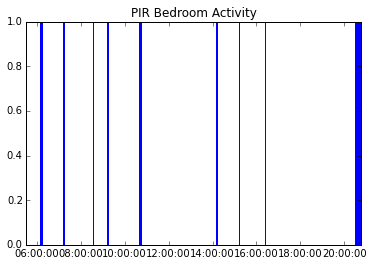

In [560]:
fig, ax = plt.subplots()
ax.stem(bedroomactivity.datetime, bedroomactivity.value, markerfmt=' ')
plt.title("PIR Bedroom Activity")
plt.show()

In [561]:
C = bedroomactivity[['sec', 'value']].values
# Fit a Dirichlet process mixture of Gaussians using five components
dpgmm = mixture.DPGMM(n_components=20, covariance_type='full', n_iter=100, init_params='wmc', params='c')
dpgmm.fit(C)

DPGMM(alpha=1.0, covariance_type='full', init_params='wmc', min_covar=None,
   n_components=20, n_iter=100, params='c', random_state=None, thresh=None,
   tol=0.001, verbose=False)

In [542]:
C[Y_ == 4, 0]

array([], dtype=float64)

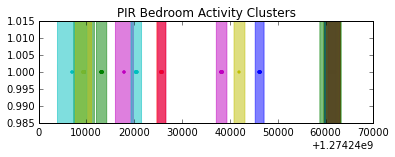

In [562]:

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
for i, (clf, title) in enumerate([(dpgmm, 'Dirichlet Process GMM')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(C)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(C[Y_ == i, 0], C[Y_ == i, 1], 5, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(0, 80000)
    #plt.ylim(0, 1.5)
    #plt.xticks(())
    #plt.yticks(())
    plt.title("PIR Bedroom Activity Clusters")

In [507]:
len(dpgmm.means_[np.unique(Y)])

12

In [514]:
C[Y_ == 5, 0]

array([], dtype=float64)

In [565]:
Y = dpgmm.predict(C)

#means = dpgmm.means_[np.unique(Y)]
#dpgmm.means_
#C[Y == 4, 0]

bedroomactivity['cluster'] = 100
#bedroomactivity.head()

for i, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        #print(C[Y_ == i, 0], C[Y_ == i, 1])
        meanx = mean[0]
        #seconds=(meanx/1000)%60
        #minutes=(meanx/(1000*60))%60
        #hours=(meanx/(3600))
        if len(C[Y==i,0]) > 0:
            print "Cluster", i, " Elements: ",len(C[Y==i,0]), " Mean ", time.strftime('%H:%M:%S', time.gmtime(mean[0]))#, " Time:", hours,":",minutes,":",seconds
            for z in enumerate(C[Y==i,0]):
                #print "---", z[1]
                bedroomactivity.loc[bedroomactivity.msseconddelta == z[1], 'cluster'] = i
                #print "Size:", pd.DataFrame(bedroomactivity.loc[bedroomactivity.msseconddelta == z[1]]).size

Cluster 1  Elements:  11  Mean  20:38:24
Cluster 2  Elements:  11  Mean  20:29:03
Cluster 3  Elements:  18  Mean  20:32:05
Cluster 4  Elements:  15  Mean  10:42:39
Cluster 5  Elements:  7  Mean  20:33:22
Cluster 6  Elements:  19  Mean  20:43:56
Cluster 7  Elements:  20  Mean  06:11:54
Cluster 8  Elements:  14  Mean  20:36:34
Cluster 9  Elements:  2  Mean  05:30:23
Cluster 10  Elements:  2  Mean  08:32:25
Cluster 11  Elements:  1  Mean  15:13:25
Cluster 12  Elements:  6  Mean  20:40:44
Cluster 13  Elements:  14  Mean  07:12:53
Cluster 14  Elements:  9  Mean  16:23:45
Cluster 15  Elements:  18  Mean  09:13:45
Cluster 16  Elements:  17  Mean  14:11:12
Cluster 17  Elements:  9  Mean  06:09:35
Cluster 18  Elements:  14  Mean  10:40:59
Cluster 19  Elements:  3  Mean  20:30:21


In [516]:
len(bedroomactivity[bedroomactivity.cluster == 100])
bedroomactivity

,datetime,sec,ms,event_type,event_subtype,sensor_id,z,x,y,value,something,seconddelta,msseconddelta,cluster
619,2010-05-19 05:30:19,1274247019,151,R,0,5,683863,146,1,1,2130706433,19819,19819.151,10
621,2010-05-19 05:30:27,1274247027,325,R,0,5,683869,146,1,1,2130706433,19827,19827.325,10
841,2010-05-19 06:09:00,1274249340,133,R,0,5,684582,146,1,1,2130706433,22140,22140.133,4
844,2010-05-19 06:09:07,1274249347,292,R,0,5,684586,146,1,1,2130706433,22147,22147.292,4
845,2010-05-19 06:09:20,1274249360,26,R,0,5,684587,146,1,1,2130706433,22160,22160.026,4
846,2010-05-19 06:09:27,1274249367,487,R,0,5,684589,146,1,1,2130706433,22167,22167.487,4
847,2010-05-19 06:09:33,1274249373,908,R,0,5,684593,146,1,1,2130706433,22173,22173.908,4
848,2010-05-19 06:09:41,1274249381,846,R,0,5,684595,146,1,1,2130706433,22181,22181.846,4
849,2010-05-19 06:09:49,1274249389,728,R,0,5,684597,146,1,1,2130706433,22189,22189.728,4
850,2010-05-19 06:09:55,1274249395,893,R,0,5,684600,146,1,1,2130706433,22195,22195.893,4


In [484]:
# gang 182 PIR
pirgangdframe = pirdframe.loc[pirdframe['x'] == 182]

In [485]:
pirgangdframe.head()

,datetime,sec,ms,event_type,event_subtype,sensor_id,z,x,y,value,something,seconddelta,msseconddelta
623,2010-05-19 05:30:30,1274247030,254,R,0,5,683872,182,1,1,2130706433,19830,19830.254
627,2010-05-19 05:30:37,1274247037,708,R,0,5,683877,182,1,1,2130706433,19837,19837.708
629,2010-05-19 05:30:45,1274247045,493,R,0,5,683879,182,1,1,2130706433,19845,19845.493
636,2010-05-19 05:30:53,1274247053,393,R,0,5,683885,182,1,1,2130706433,19853,19853.393
637,2010-05-19 05:30:59,1274247059,923,R,0,5,683888,182,1,1,2130706433,19859,19859.923


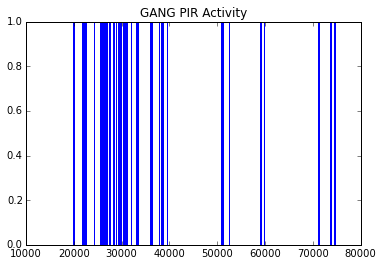

In [518]:
fig, ax = plt.subplots()
ax.stem(pirgangdframe.msseconddelta, pirgangdframe.value, markerfmt=' ')
plt.title("GANG PIR Activity")
plt.show()